## Baseline model for bus 211


This notebook creates a baseline model for bus 211, and calculates the prediction error on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import pickle
import math
%matplotlib inline
sns.set()

In [2]:
train = pickle.load(open('../211_train_new.p', 'rb'))
test = pickle.load(open('../211_test_new.p', 'rb'))

In [3]:
# convert timestamp columns to pandas datetimes
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['timestamp'] = train['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['timestamp'] = test['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

In [4]:
# sanity check
print('train data rows comprise {:.4f}% of the total data'
      .format(len(train.index) / (len(train.index) + len(test.index))))
print('test data rows comprise {:.4f}% of the total data'
      .format(len(test.index) / (len(train.index) + len(test.index))))

train data rows comprise 0.7989% of the total data
test data rows comprise 0.2011% of the total data


### Calculate the median travel times for each segment in the train data

In [5]:
train.head(1)

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16 07:03:00+01:00,JourneyStartedEvent,5333,211,58.417591,15.622906,-1.0,-1.0,NaN,1,1


Now lets calculate the median travel time in the segments of the train data, which will be used to make predictions.

In [6]:
def get_travel_time(x):
    """
    Get the travel time within the current segment
    """
    timedelta = x.max() - x.min()
    return timedelta.seconds

In [7]:
# get segment time for each segment in each journey
train['segment_time'] = train.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

In [8]:
test['segment_time'] = test.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

Now we want to get the average time it took to drive each segment. Since we have the segment time duplicated over all rows with the same journey number and segment number, we need to only take this number once to not get a skewed weighting of the average. We can group by journey_number and segment_number, and take any aggregate function (min, max, mean) since the segment time is the same for each row where the journey number and segment number are the same.

In [9]:
a = train.groupby(['journey_number', 'segment_number']).min().reset_index()

In [10]:
medians = dict(a.groupby('segment_number')['segment_time'].median())

These are our median travel times for each segment:

In [11]:
medians

{1: 250.0,
 2: 87.0,
 3: 163.0,
 4: 28.0,
 5: 49.0,
 6: 54.0,
 7: 74.0,
 8: 98.0,
 9: 34.5,
 10: 41.0,
 11: 69.0,
 12: 49.0}

In [12]:
pickle.dump(medians, open('medians_211.p', 'wb'))

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through the test data and make predictions using the median travel times for each segment. Comments in code below describes the procedure.

In [13]:
 def get_prediction_error(start_time, segment_name, segment_data):
    # min() becomes the min timestamp of this slice, 
    # while start_time is the min timestamp on the whole segment 
    timedelta = segment_data['timestamp'].min() - start_time
    # get how much time the bus has already spent in this slice of the segment
    time_passed = timedelta.seconds
    # subtract that from the total time the segment takes    
    time_left = segment_data['segment_time'].iloc[0] - time_passed
    # subtract the spend time from our prediction as well
    time_pred = medians[segment_name] - time_passed
    # get the error in seconds from our prediction vs the true travel time
    error_s = time_left - time_pred
    # get error as a percentage of the true travel time left
    error_p = error_s / time_left * 100
    # get absolute values of the errors
    abs_error_s = abs(error_s)
    abs_error_p = abs(error_p)
    return error_s, error_p, abs_error_s, abs_error_p

In [14]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    intervals = [(math.floor(seg_len * i/10), f'{i}0_p') for i in range(0, 10, 2)]
    start_time = group['timestamp'].min()
    # calculate our errors for each slice of the segment
    for (idx, interval) in intervals: 
        error_s, error_p, abs_error_s, abs_error_p = get_prediction_error(start_time, name[1], group[idx:])
        data.append([name[1], interval, error_s, error_p, abs_error_s, abs_error_p])

In [15]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [16]:
error_df.head(5)

,segment,slice,error_s,error_p,abs_error_s,abs_error_p
0,1,00_p,-54.0,-27.551020,54.0,27.551020
1,1,20_p,-54.0,-34.394904,54.0,34.394904
2,1,40_p,-54.0,-46.153846,54.0,46.153846
3,1,60_p,-54.0,-68.354430,54.0,68.354430
4,1,80_p,-54.0,-138.461538,54.0,138.461538


# ERROR RESULTS HERE

Dataframe above holds our prediction errors on the test set. To can now get our MAPE for the segments and the segment slices, by looking at the means of the `abs_error_p` column. The values of the column "slice", such as `20_p`, `40_p`, means predictions after travelling 20%, 40% etc.

In [17]:
print('MAPE: {:.2f}%'.format(error_df[error_df.slice != '00_p']['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df[error_df.slice != '00_p']['abs_error_s'].mean()))

MAPE: 55.11%
MAE: 16.55s


In [18]:
# Including 0-100% slice (slice == 00_p included)
print('MAPE: {:.2f}%'.format(error_df['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df['abs_error_s'].mean()))

MAPE: 48.32%
MAE: 16.55s


In [19]:
error_df.groupby('slice').mean()

,segment,error_s,error_p,abs_error_s,abs_error_p
slice,,,,,
00_p,6.5,2.849383,-3.210122,16.554938,21.171644
20_p,6.5,2.849383,-3.398137,16.554938,25.564948
40_p,6.5,2.849383,-4.795093,16.554938,34.102799
60_p,6.5,2.849383,-7.699722,16.554938,51.741079
80_p,6.5,2.849383,-18.056497,16.554938,109.037331


In [20]:
error_df.groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,-2.785185,-16.294280,38.400000,42.641719
2,9.474074,-3.153040,26.140741,63.697475
3,4.951852,-3.790327,29.300000,40.771026
4,3.181481,3.208246,8.055556,54.174367
5,-1.737037,-29.971346,10.722222,62.206492
6,0.425926,-12.732822,9.248148,44.310497
7,1.418519,-4.473699,11.551852,34.315642
8,5.703704,1.144255,18.466667,39.223611
9,0.729630,-14.794795,9.062963,62.509537


In [21]:
# without 0%-100% slice/complete segment (slice == 00_p)
error_df[error_df.slice != '00_p'].groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,-2.785185,-18.568650,38.400000,48.612672
2,9.474074,-3.602717,26.140741,72.644811
3,4.951852,-4.269068,29.300000,46.571934
4,3.181481,3.596278,8.055556,61.781678
5,-1.737037,-34.231618,10.722222,70.972787
6,0.425926,-14.517882,9.248148,50.519096
7,1.418519,-5.109750,11.551852,39.125738
8,5.703704,1.289042,18.466667,44.725029
9,0.729630,-16.869076,9.062963,71.254445


In [22]:
error_df.groupby(['segment', 'slice']).mean()

error_s    error_p  abs_error_s  abs_error_p
segment slice                                               
1       00_p  -2.785185  -7.196802    38.400000    18.757906
        20_p  -2.785185  -8.822344    38.400000    23.192246
        40_p  -2.785185 -11.719169    38.400000    30.930664
        60_p  -2.785185 -17.752405    38.400000    46.505198
        80_p  -2.785185 -35.980682    38.400000    93.822580
2       00_p   9.474074  -1.354333    26.140741    27.908130
        20_p   9.474074  -1.298817    26.140741    33.918547
        40_p   9.474074  -1.832558    26.140741    45.305109
        60_p   9.474074  -2.953804    26.140741    68.690645
        80_p   9.474074  -8.325690    26.140741   142.664942
3       00_p   4.951852  -1.875359    29.300000    17.567395
        20_p   4.951852  -2.206878    29.300000    21.799496
        40_p   4.951852  -2.997673    29.300000    29.095422
        60_p   4.951852  -3.829525    29.300000    44.648769
        80_p   4.951852  -8.042197    29.300000    90.744048
4       00_p   3.181481   1.656116     8.055556    23.745124
        20_p   3.181481   3.035978     8.055556    28.248028
        40_p   3.181481   3.638883     8.055556    37.793413
        60_p   3.181481   3.860693     8.055556    57.099911
        80_p   3.181481   3.849559     8.055556   123.985361
5       00_p  -1.737037 -12.930254    10.722222    27.141312
        20_p  -1.737037 -14.691245    10.722222    32.200943
        40_p  -1.737037 -20.082111    10.722222    43.161196
        60_p  -1.737037 -31.463391    10.722222    66.024145
        80_p  -1.737037 -70.689727    10.722222   142.504865
6       00_p   0.425926  -5.592583     9.248148    19.476100
        20_p   0.425926  -6.221223     9.248148    23.417818
        40_p   0.425926  -8.616821     9.248148    31.180924
        60_p   0.425926 -13.267815     9.248148    47.188567
        80_p   0.425926 -29.965670     9.248148   100.289074
7       00_p   1.418519  -1.929497    11.551852    15.075260
        20_p   1.418519  -2.140418    11.551852    18.355999
        40_p   1.418519  -3.076695    11.551852    24.405880
        60_p   1.418519  -4.747075    11.551852    37.001209
        80_p   1.418519 -10.474812    11.551852    76.739862
8       00_p   5.703704   0.565105    18.466667    17.217938
        20_p   5.703704   0.780241    18.466667    21.029141
        40_p   5.703704   0.997607    18.466667    28.074151
        60_p   5.703704   1.361738    18.466667    42.493518
        80_p   5.703704   2.016582    18.466667    87.303307
9       00_p   0.729630  -6.497668     9.062963    27.529903
        20_p   0.729630  -6.607503     9.062963    32.503481
        40_p   0.729630  -9.121217     9.062963    43.634345
        60_p   0.729630 -15.421100     9.062963    65.976281
        80_p   0.729630 -36.326486     9.062963   142.903673
10      00_p   4.425926   4.647785     9.107407    18.951846
        20_p   4.425926   6.113993     9.107407    22.926350
        40_p   4.425926   7.537366     9.107407    30.255014
        60_p   4.425926  11.047481     9.107407    45.993633
        80_p   4.425926  21.366313     9.107407    97.932450
11      00_p   2.511111  -1.755164    12.029630    16.430531
        20_p   2.511111  -1.888148    12.029630    20.081745
        40_p   2.511111  -2.604726    12.029630    26.510116
        60_p   2.511111  -4.161122    12.029630    40.138758
        80_p   2.511111  -9.189523    12.029630    83.521359
12      00_p   5.892593  -6.258813    16.574074    24.258282
        20_p   5.892593  -6.831275    16.574074    29.105582
        40_p   5.892593  -9.663999    16.574074    38.887352
        60_p   5.892593 -15.070344    16.574074    59.132312
        80_p   5.892593 -34.915636    16.574074   126.036451

In [23]:
error_df.groupby(['slice', 'segment']).mean()

error_s    error_p  abs_error_s  abs_error_p
slice segment                                               
00_p  1       -2.785185  -7.196802    38.400000    18.757906
      2        9.474074  -1.354333    26.140741    27.908130
      3        4.951852  -1.875359    29.300000    17.567395
      4        3.181481   1.656116     8.055556    23.745124
      5       -1.737037 -12.930254    10.722222    27.141312
      6        0.425926  -5.592583     9.248148    19.476100
      7        1.418519  -1.929497    11.551852    15.075260
      8        5.703704   0.565105    18.466667    17.217938
      9        0.729630  -6.497668     9.062963    27.529903
      10       4.425926   4.647785     9.107407    18.951846
      11       2.511111  -1.755164    12.029630    16.430531
      12       5.892593  -6.258813    16.574074    24.258282
20_p  1       -2.785185  -8.822344    38.400000    23.192246
      2        9.474074  -1.298817    26.140741    33.918547
      3        4.951852  -2.206878    29.300000    21.799496
      4        3.181481   3.035978     8.055556    28.248028
      5       -1.737037 -14.691245    10.722222    32.200943
      6        0.425926  -6.221223     9.248148    23.417818
      7        1.418519  -2.140418    11.551852    18.355999
      8        5.703704   0.780241    18.466667    21.029141
      9        0.729630  -6.607503     9.062963    32.503481
      10       4.425926   6.113993     9.107407    22.926350
      11       2.511111  -1.888148    12.029630    20.081745
      12       5.892593  -6.831275    16.574074    29.105582
40_p  1       -2.785185 -11.719169    38.400000    30.930664
      2        9.474074  -1.832558    26.140741    45.305109
      3        4.951852  -2.997673    29.300000    29.095422
      4        3.181481   3.638883     8.055556    37.793413
      5       -1.737037 -20.082111    10.722222    43.161196
      6        0.425926  -8.616821     9.248148    31.180924
      7        1.418519  -3.076695    11.551852    24.405880
      8        5.703704   0.997607    18.466667    28.074151
      9        0.729630  -9.121217     9.062963    43.634345
      10       4.425926   7.537366     9.107407    30.255014
      11       2.511111  -2.604726    12.029630    26.510116
      12       5.892593  -9.663999    16.574074    38.887352
60_p  1       -2.785185 -17.752405    38.400000    46.505198
      2        9.474074  -2.953804    26.140741    68.690645
      3        4.951852  -3.829525    29.300000    44.648769
      4        3.181481   3.860693     8.055556    57.099911
      5       -1.737037 -31.463391    10.722222    66.024145
      6        0.425926 -13.267815     9.248148    47.188567
      7        1.418519  -4.747075    11.551852    37.001209
      8        5.703704   1.361738    18.466667    42.493518
      9        0.729630 -15.421100     9.062963    65.976281
      10       4.425926  11.047481     9.107407    45.993633
      11       2.511111  -4.161122    12.029630    40.138758
      12       5.892593 -15.070344    16.574074    59.132312
80_p  1       -2.785185 -35.980682    38.400000    93.822580
      2        9.474074  -8.325690    26.140741   142.664942
      3        4.951852  -8.042197    29.300000    90.744048
      4        3.181481   3.849559     8.055556   123.985361
      5       -1.737037 -70.689727    10.722222   142.504865
      6        0.425926 -29.965670     9.248148   100.289074
      7        1.418519 -10.474812    11.551852    76.739862
      8        5.703704   2.016582    18.466667    87.303307
      9        0.729630 -36.326486     9.062963   142.903673
      10       4.425926  21.366313     9.107407    97.932450
      11       2.511111  -9.189523    12.029630    83.521359
      12       5.892593 -34.915636    16.574074   126.036451

## Plotting histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


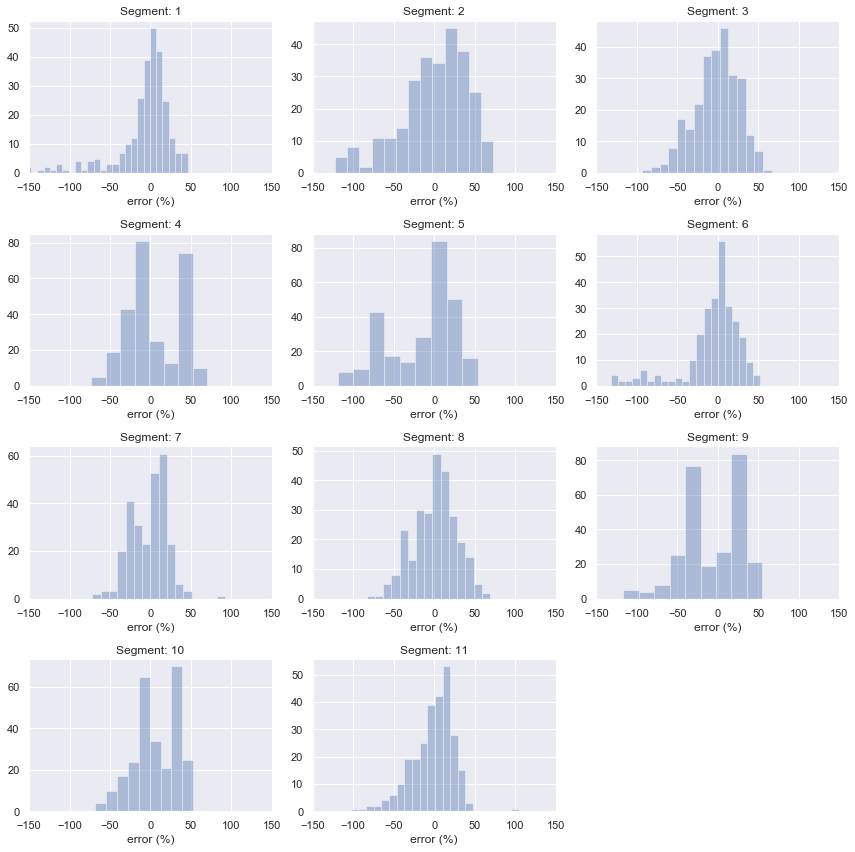

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


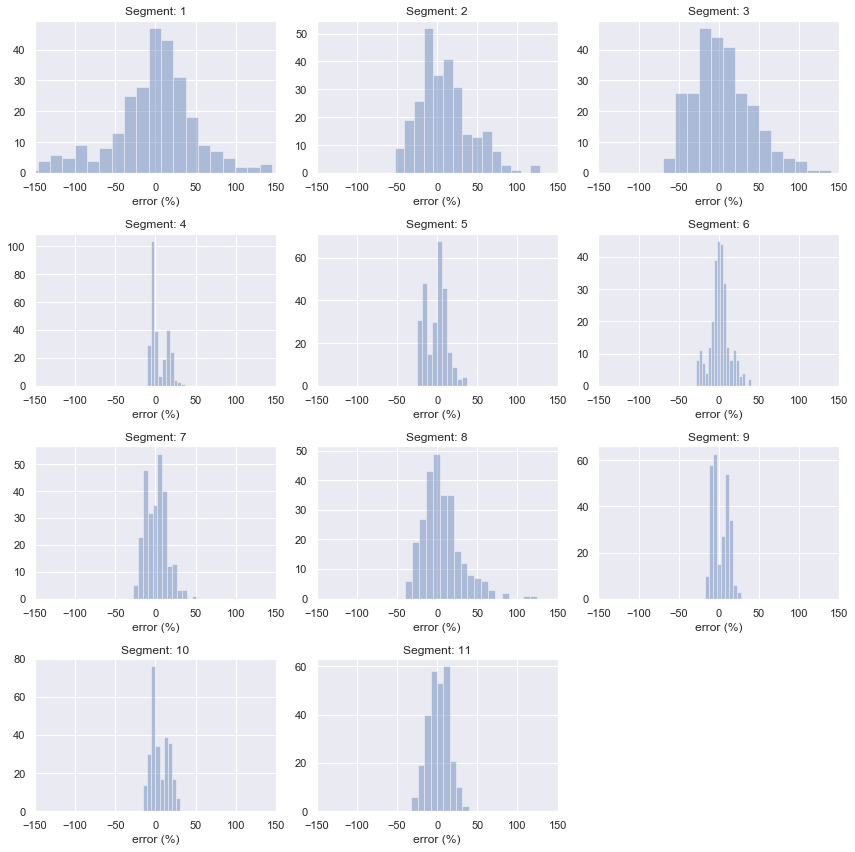

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()